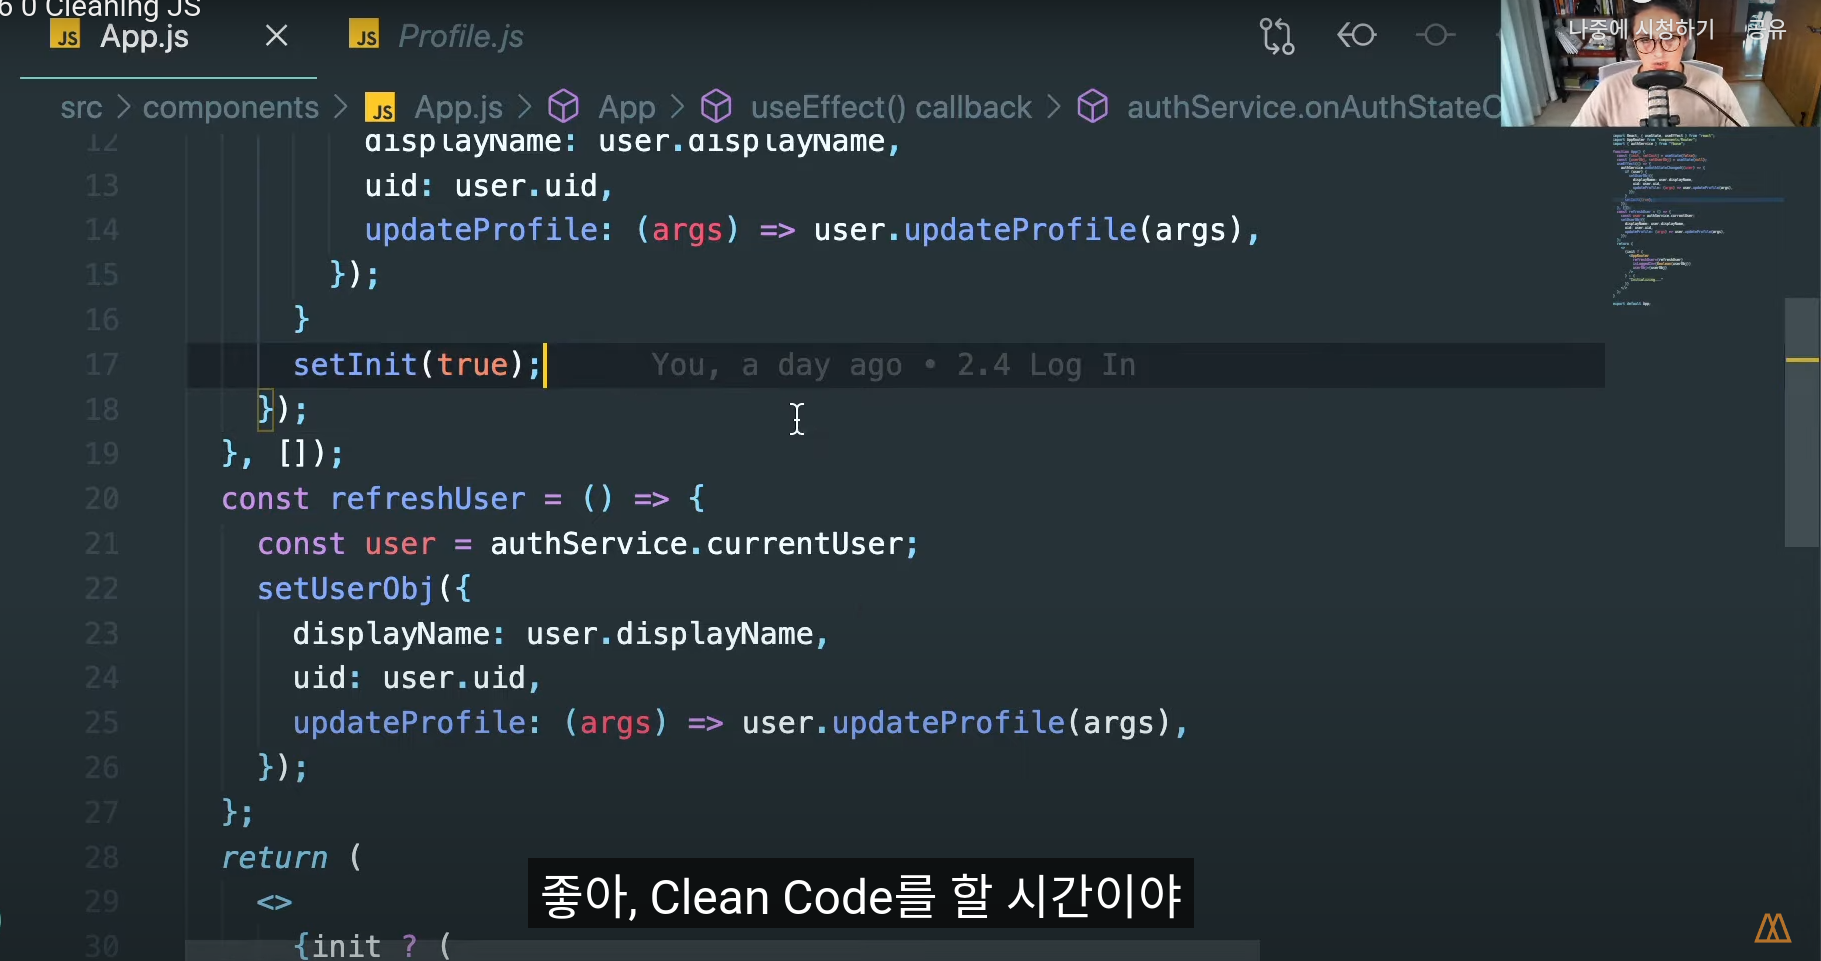

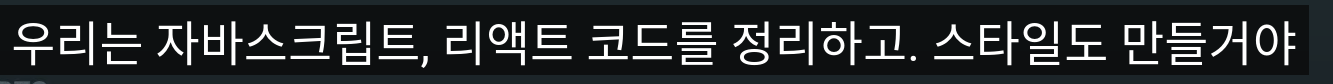

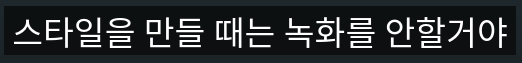

# Home.js - 클린코드 전
```jsx
import { useState, useEffect } from "react";
// firestore - https://firebase.google.com/docs/firestore/quickstart?hl=ko#web-version-9
import {
  collection,
  addDoc,
  // getDocs,
  query,
  orderBy,
  onSnapshot,
} from "firebase/firestore";
// storage - https://firebase.google.com/docs/storage/web/upload-files
import { ref, uploadString, getDownloadURL } from "firebase/storage";

// yarn add uuid - 특별식별자를 랜덤으로 생성
import { v4 as uuidv4 } from "uuid";

import { dbService, storageService } from "fbase";
import Jweet from "components/Jweet";

function Home({ userObj }) {
  const [jweet, setJweet] = useState("");
  const [jweets, setJweets] = useState([]);
  // 이미지url를 담을 state
  const [attachment, setAttachment] = useState("");

  useEffect(() => {
    // 실시간으로 데이터를 데이터베이스에서 가져오기
    const q = query(
      collection(dbService, "jweets"),
      // where('text', '==', 'hehe') // where뿐만아니라 각종 조건 이 영역에 때려부우면 됨
      orderBy("createdAt", "desc")
    );
    const unsubscribe = onSnapshot(q, (querySnapshot) => {
      const newArray = querySnapshot.docs.map((doc) => {
        return {
          id: doc.id,
          ...doc.data(),
        };
      });
      setJweets(newArray);
    });

    return () => {
      unsubscribe();
    };
  }, []);

  const onSubmit = async (event) => {
    event.preventDefault();
    let attachmentUrl = "";
    // 이미지 첨부하지 않고 텍스트만 올리고 싶을 때도 있기 때문에
    // attachment가 있을때만 아래 코드 실행
    //이미지 첨부하지 않은 경우엔 attachmentUrl=""이 된다.
    if (attachment) {
      // 파일 경로 참조 만들기
      const fileRef = ref(storageService, `${userObj.uid}/${uuidv4()}`);
      // storage 참조 경로로 파일 업로드 하기
      const response = await uploadString(fileRef, attachment, "data_url");
      // storage 참조 경로에 있는 파일의 URL을 다운로드해서 attachmentUrl 변수에 넣어서 업데이트
      attachmentUrl = await getDownloadURL(response.ref);
    }
    // jweet obj
    const jweetObj = {
      text: jweet,
      createdAt: Date.now(),
      creatorId: userObj.uid,
      attachmentUrl,
    };
    // 저장
    await addDoc(collection(dbService, "jweets"), jweetObj);
    // state 비워서 form 비우기
    setJweet("");
    // 파일 미리보기 img src 비워주기
    setAttachment("");
  };

  const onChange = (event) => {
    const {
      target: { value },
    } = event;
    setJweet(value);
  };

  const onFileChange = (event) => {
    // console.log(event.target.files);
    const {
      target: { files },
    } = event;

    const theFile = files[0];
    // FileReader API -> 검색
    const reader = new FileReader();

    // 2.파일리더에 after이벤트를 붙임
    reader.onloadend = (finishedEvent) => {
      // 3. 사진 string get
      const {
        currentTarget: { result },
      } = finishedEvent;
      // 4. state에 담기
      setAttachment(result);
    };
    // 1.파일을 읽음
    reader.readAsDataURL(theFile);
  };
  const onClickClearAttachment = () => setAttachment("");
  return (
    <>
      <form onSubmit={onSubmit}>
        <input
          type="text"
          placeholder="What's on your mind?"
          maxLength={120}
          onChange={onChange}
          value={jweet}
        />
        <input type="file" accept="image/*" onChange={onFileChange} />
        <input type="submit" value="Jweet" />
        {attachment && (
          <>
            <img
              src={attachment}
              width="50px"
              height="50px"
              alt="upload_image"
            />
            <button onClick={onClickClearAttachment}>Cancel</button>
          </>
        )}
      </form>
      <div>
        {jweets.map((jweet) => {
          return (
            <Jweet
              key={jweet.id}
              jweetObj={jweet}
              isOwner={jweet.creatorId === userObj.uid}
            />
          );
        })}
      </div>
    </>
  );
}

export default Home;
```

# JweetFactory.js 
## Jweets 생성을 담당
```js
import { dbService, storageService } from "fbase";
import { addDoc, collection } from "firebase/firestore";
import { getDownloadURL, ref, uploadString } from "firebase/storage";
import { useState } from "react";
import { v4 as uuidv4 } from "uuid";

function JweetFactory({ userObj }) {
  const [jweet, setJweet] = useState("");
  const [attachment, setAttachment] = useState("");

  const onSubmit = async (event) => {
    event.preventDefault();
    let attachmentUrl = "";
    // 이미지 첨부하지 않고 텍스트만 올리고 싶을 때도 있기 때문에
    // attachment가 있을때만 아래 코드 실행
    //이미지 첨부하지 않은 경우엔 attachmentUrl=""이 된다.
    if (attachment) {
      // 파일 경로 참조 만들기
      const fileRef = ref(storageService, `${userObj.uid}/${uuidv4()}`);
      // storage 참조 경로로 파일 업로드 하기
      const response = await uploadString(fileRef, attachment, "data_url");
      // storage 참조 경로에 있는 파일의 URL을 다운로드해서 attachmentUrl 변수에 넣어서 업데이트
      attachmentUrl = await getDownloadURL(response.ref);
    }
    // jweet obj
    const jweetObj = {
      text: jweet,
      createdAt: Date.now(),
      creatorId: userObj.uid,
      attachmentUrl,
    };
    // 저장
    await addDoc(collection(dbService, "jweets"), jweetObj);
    // state 비워서 form 비우기
    setJweet("");
    // 파일 미리보기 img src 비워주기
    setAttachment("");
  };

  const onChange = (event) => {
    const {
      target: { value },
    } = event;
    setJweet(value);
  };

  const onFileChange = (event) => {
    // console.log(event.target.files);
    const {
      target: { files },
    } = event;

    const theFile = files[0];
    // FileReader API -> 검색
    const reader = new FileReader();

    // 2.파일리더에 after이벤트를 붙임
    reader.onloadend = (finishedEvent) => {
      // 3. 사진 string get
      const {
        currentTarget: { result },
      } = finishedEvent;
      // 4. state에 담기
      setAttachment(result);
    };
    // 1.파일을 읽음
    reader.readAsDataURL(theFile);
  };
  const onClickClearAttachment = () => setAttachment("");
  return (
    <>
      <form onSubmit={onSubmit}>
        <input
          type="text"
          placeholder="What's on your mind?"
          maxLength={120}
          onChange={onChange}
          value={jweet}
        />
        <input type="file" accept="image/*" onChange={onFileChange} />
        <input type="submit" value="Jweet" />
        {attachment && (
          <>
            <img
              src={attachment}
              width="50px"
              height="50px"
              alt="upload_image"
            />
            <button onClick={onClickClearAttachment}>Cancel</button>
          </>
        )}
      </form>
    </>
  );
}

export default JweetFactory;

```

#  Clean Home.js
```jsx
import { useState, useEffect } from "react";
import { collection, query, orderBy, onSnapshot } from "firebase/firestore";
import { dbService } from "fbase";
import Jweet from "components/Jweet";
import JweetFactory from "components/JweetFactory";

function Home({ userObj }) {
  const [jweets, setJweets] = useState([]);
  // 이미지url를 담을 state

  useEffect(() => {
    // 실시간으로 데이터를 데이터베이스에서 가져오기
    const q = query(
      collection(dbService, "jweets"),
      // where('text', '==', 'hehe') // where뿐만아니라 각종 조건 이 영역에 때려부우면 됨
      orderBy("createdAt", "desc")
    );
    const unsubscribe = onSnapshot(q, (querySnapshot) => {
      const newArray = querySnapshot.docs.map((doc) => {
        return {
          id: doc.id,
          ...doc.data(),
        };
      });
      setJweets(newArray);
    });

    return () => {
      unsubscribe();
    };
  }, []);

  return (
    <>
      <JweetFactory userObj={userObj} />
      <div>
        {jweets.map((jweet) => {
          return (
            <Jweet
              key={jweet.id}
              jweetObj={jweet}
              isOwner={jweet.creatorId === userObj.uid}
            />
          );
        })}
      </div>
    </>
  );
}

export default Home;

```

# Clean 전 Auth.js
```jsx
import { useState } from "react";
import { authService } from "fbase";

// firebase - Persistence browserSessionPersistence
// https://firebase.google.com/docs/auth/web/auth-state-persistence?authuser=1&hl=ko

// firebase - login signInWithEmailAndPassword, createUserWithEmailAndPassword
// https://firebase.google.com/docs/auth/web/start?hl=ko&authuser=1

// Google - https://firebase.google.com/docs/reference/js/auth.googleauthprovider?hl=ko#googleauthprovidergoogle_sign_in_method
import {
  createUserWithEmailAndPassword,
  signInWithEmailAndPassword,
  GithubAuthProvider, // - git Auth
  GoogleAuthProvider, // - google Auth
  signInWithPopup, // popup -with api login
} from "firebase/auth";

function Auth() {
  const [email, setEmail] = useState("");
  const [password, setPassword] = useState("");
  const [newAccount, setNewAccount] = useState(true);
  const [error, setError] = useState("");

  const onChange = (event) => {
    const {
      target: { name, value },
    } = event;
    if (name === "email") {
      setEmail(value);
    } else if (name === "password") {
      setPassword(value);
    }
  };
  const onSubmit = async (event) => {
    event.preventDefault();
    try {
      if (newAccount) {
        // create account
        await createUserWithEmailAndPassword(authService, email, password);
      } else {
        // log in
        await signInWithEmailAndPassword(authService, email, password);
      }
    } catch (error) {
      setError(error.message);
    }
  };

  const toggleAccount = () => setNewAccount((prev) => !prev);
  const onSocialClick = async (event) => {
    const {
      target: { name },
    } = event;
    let provider;
    if (name === "google") {
      provider = new GoogleAuthProvider();
    } else if (name === "github") {
      provider = new GithubAuthProvider();
    }
    const data = await signInWithPopup(authService, provider);
    console.log(data);
  };

  return (
    <>
      <form onSubmit={onSubmit}>
        <input
          name="email"
          type="email"
          placeholder="Email"
          required
          value={email}
          onChange={onChange}
        />
        <input
          name="password"
          type="password"
          placeholder="Password"
          required
          value={password}
          onChange={onChange}
        />
        <input type="submit" value={newAccount ? "Create Account" : "Log In"} />
        {error}
      </form>
      <span onClick={toggleAccount}>
        {newAccount ? "Log in" : "Create Account"}
      </span>
      <div>
        <button name="google" onClick={onSocialClick}>
          Continue with Google
        </button>
        <button name="github" onClick={onSocialClick}>
          Continue with Github
        </button>
      </div>
    </>
  );
}

export default Auth;

```

# create AuthForm.js
```jsx
import { useState } from "react";
import { authService } from "fbase";
import {
  createUserWithEmailAndPassword,
  signInWithEmailAndPassword,
} from "firebase/auth";

function AuthForm() {
  const [email, setEmail] = useState("");
  const [password, setPassword] = useState("");
  const [newAccount, setNewAccount] = useState(true);
  const [error, setError] = useState("");

  const onChange = (event) => {
    const {
      target: { name, value },
    } = event;
    if (name === "email") {
      setEmail(value);
    } else if (name === "password") {
      setPassword(value);
    }
  };

  const onSubmit = async (event) => {
    event.preventDefault();
    try {
      if (newAccount) {
        // create account
        await createUserWithEmailAndPassword(authService, email, password);
      } else {
        // log in
        await signInWithEmailAndPassword(authService, email, password);
      }
    } catch (error) {
      setError(error.message);
    }
  };

  const toggleAccount = () => setNewAccount((prev) => !prev);
  return (
    <>
      <form onSubmit={onSubmit}>
        <input
          name="email"
          type="email"
          placeholder="Email"
          required
          value={email}
          onChange={onChange}
        />
        <input
          name="password"
          type="password"
          placeholder="Password"
          required
          value={password}
          onChange={onChange}
        />
        <input type="submit" value={newAccount ? "Create Account" : "Log In"} />
        {error}
      </form>
      <span onClick={toggleAccount}>
        {newAccount ? "Log in" : "Create Account"}
      </span>
    </>
  );
}

export default AuthForm;

```

# clean Auth.js
```jsx
import { authService } from "fbase";
import {
  GithubAuthProvider, // - git Auth
  GoogleAuthProvider, // - google Auth
  signInWithPopup, // popup -with api login
} from "firebase/auth";
import AuthForm from "components/AuthForm";

function Auth() {
  const onSocialClick = async (event) => {
    const {
      target: { name },
    } = event;
    let provider;
    if (name === "google") {
      provider = new GoogleAuthProvider();
    } else if (name === "github") {
      provider = new GithubAuthProvider();
    }
    const data = await signInWithPopup(authService, provider);
    console.log(data);
  };

  return (
    <>
      <AuthForm />
      <div>
        <button name="google" onClick={onSocialClick}>
          Continue with Google
        </button>
        <button name="github" onClick={onSocialClick}>
          Continue with Github
        </button>
      </div>
    </>
  );
}

export default Auth;

// firebase - Persistence browserSessionPersistence
// https://firebase.google.com/docs/auth/web/auth-state-persistence?authuser=1&hl=ko

// firebase - login signInWithEmailAndPassword, createUserWithEmailAndPassword
// https://firebase.google.com/docs/auth/web/start?hl=ko&authuser=1

// Google - https://firebase.google.com/docs/reference/js/auth.googleauthprovider?hl=ko#googleauthprovidergoogle_sign_in_method

```